In [198]:
from cvxpy import *
import numpy as np
import matplotlib.pylab as plt

def kappa(gram):
    n = len(gram)
    e = np.ones(n)
    return np.outer(np.diag(gram),e) + np.outer(e,np.diag(gram).T) - 2*gram

def kappa_cvx(gram, n):
    e = np.ones((n,1))
    return diag(gram)*e.T + e*diag(gram).T - 2*gram

In [199]:
from point_configuration import PointConfiguration

## Setup
n = 10
d = 3
e = np.ones(n)
p = PointConfiguration(n, d)
p.set_points(mode='normal')


gram = p.points.dot(p.points.T)
assert np.allclose(kappa(gram), p.edm)

W = np.ones([n,n])
print('trace of gram:',np.trace(gram))
V = np.c_[-np.ones(n-1)/np.sqrt(n), np.eye(n-1)-np.ones([n-1,n-1])/(n+np.sqrt(n))].T

trace of gram: 20.6158620168


In [200]:
## SDP Problem

# Creates a n-1 by n-1 positive semidefinite variable.
lamda = 100000
H = Semidef(n-1)
G = V*H*V.T # * is overloaded 
EDM = kappa_cvx(G, n) 

obj = Maximize(trace(H) - lamda*norm(mul_elemwise(W,(EDM-p.edm))))
prob = Problem(obj)

In [202]:
## Solution
from basics import eigendecomp
from algorithms import reconstruct_mds

print('Objective:',prob.solve(verbose=True))

Gbest = V*H.value*V.T
EDMbest = kappa(Gbest) 

Ubest, Sbest, Vbest = np.linalg.svd(Gbest)

Xhat = reconstruct_mds(EDMbest, p.points, method='geometric')
# TODO: why does this not work? 
#factor, u = eigendecomp(Gbest, d)
#Xhat = np.diag(factor).dot(u.T)[:d]

# TODO why do these two not sum up to the objective? 
print('trace of H:',np.trace(H.value))
print('other cost:',lamda*norm(mul_elemwise(W,(EDMbest-p.edm))).value)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 5455, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 446, constraints m = 745
Cones:	primal zero / dual free vars: 490
	sd vars: 255, sd blks: 2
Setup time: 2.30e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  3.48e-02 
   100| 1.20e-06  1.63e-06  1.06e-03 -2.01e+01 -2.01e+01  5.50e-11  8.34e-02 
   120| 2.81e-07  2.98e-07  9.01e-04 -2.00e+01 -2.00e+01  5.50e-11  9.20e-02 
------------------

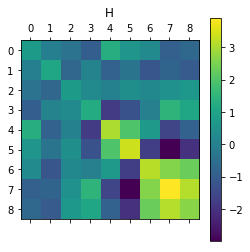

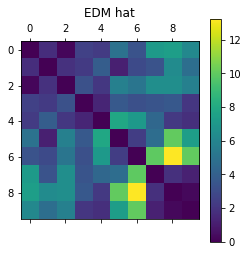

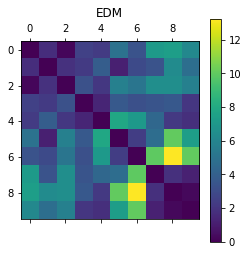

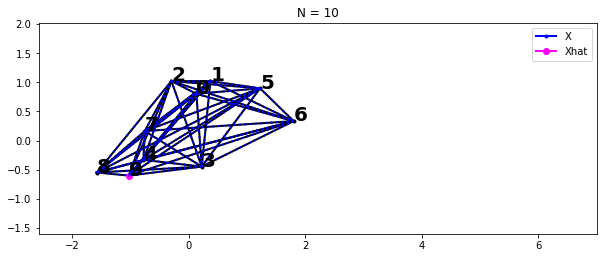

mse: 1.29088034166e-07


In [203]:
from plots_cti import plot_point_sets, plot_matrix
plot_matrix(H.value, 'H')
plot_matrix(EDMbest, 'EDM hat')
plot_matrix(p.edm, 'EDM')
plot_point_sets([p.points,Xhat],names=['X','Xhat'],display_lines=True)
print('mse:',np.linalg.norm(p.points-Xhat)/len(Xhat))